# Basic_CNN

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Path setup
train_dir = 'data/images_train'
test_dir = 'data/images_test'
train_csv = pd.read_csv('data/train.csv')
test_csv = pd.read_csv('data/test.csv')

In [3]:
# Input image size
original_image_size = (539, 529)
input_image_size = (224, 219) # with ratio preserved

# Preparing data
def load_images_and_labels(csv, directory):
    images = []
    labels = []
    for _, row in csv.iterrows():
        img_name = str(row['id']) + '.png'
        img_path = os.path.join(directory, img_name)
        img = image.load_img(img_path, color_mode='grayscale', target_size=input_image_size)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)
        labels.append(row['ground_truth'])
    images = np.vstack(images)
    labels = np.array(labels)
    return images, labels

X_train, y_train = load_images_and_labels(train_csv, train_dir)
X_test, y_test = load_images_and_labels(test_csv, test_dir)

In [4]:
# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

In [52]:
# CNN Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 219, 1)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid'),
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()

C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 222, 217, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 383616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │   196,411,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,412,737 (749.26 MB)

 Trainable params: 196,412,737 (749.26 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Train the model
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
  1/107 ━━━━━━━━━━━━━━━━━━━━ 1:47:09 61s/step - accuracy: 0.4688 - loss: 0.6976

KeyboardInterrupt: 

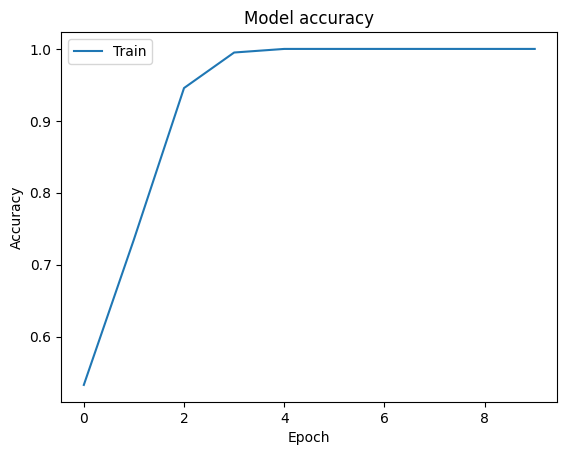

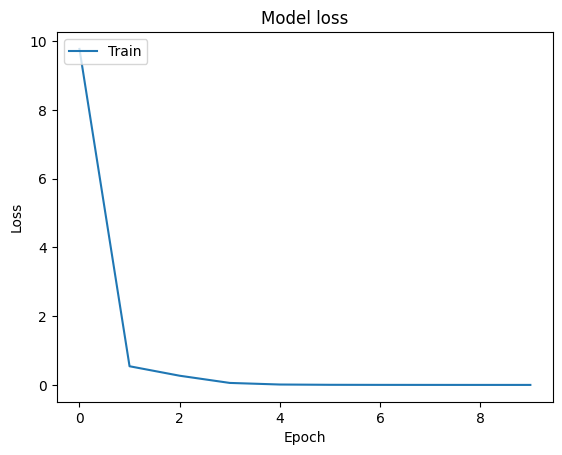

In [28]:
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [26]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5935 - loss: 1.1273
Test Accuracy: 60.52%


## CNN Architecture with Dropout and L2 regularization

In [40]:
# Set up data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,      # random rotations
    width_shift_range=0.2,  # random width shifts
    height_shift_range=0.2, # random height shifts
    horizontal_flip=True,   # random horizontal flips
    zoom_range=0.2          # random zooming
)

# CNN Architecture with Dropout and L2 regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1), kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

# Early stopping setup
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Fit the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32), # train with data augmentation
    validation_data=(X_test, y_test),
    epochs=50, # increased number of epochs due to potential slower convergence with data augmentation
    callbacks=[early_stopping]
)

# After training, evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: {:.2f}%".format(scores[1]*100))
print("Test loss: {:.4f}".format(scores[0]))

C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │   264,258,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,258,881 (1008.07 MB)

 Trainable params: 264,258,881 (1008.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.4831 - loss: 15.1321 - val_accuracy: 0.5127 - val_loss: 1.1187
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5368 - loss: 0.9792 - val_accuracy: 0.5202 - val_loss: 0.7868
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5362 - loss: 0.7869 - val_accuracy: 0.5517 - val_loss: 0.7678
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5383 - loss: 0.7688 - val_accuracy: 0.5223 - val_loss: 0.7464
Epoch 5/50
 75/107 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5572 - loss: 0.7648

KeyboardInterrupt: 

## CNN Architecture with BatchNormalization

In [34]:
from tensorflow.keras.layers import BatchNormalization

# Updated CNN Architecture with Batch Normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Fit the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping]
)

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: {:.2f}%".format(scores[1]*100))
print("Test loss: {:.4f}".format(scores[0]))


C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,001,409 (240.33 MB)

 Trainable params: 63,000,705 (240.33 MB)

 Non-trainable params: 704 (2.75 KB)

C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 93s 852ms/step - accuracy: 0.5712 - loss: 10.5220 - val_accuracy: 0.5072 - val_loss: 8.1518
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 90s 844ms/step - accuracy: 0.5711 - loss: 4.4194 - val_accuracy: 0.5147 - val_loss: 4.7272
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 91s 853ms/step - accuracy: 0.5443 - loss: 4.2911 - val_accuracy: 0.5120 - val_loss: 5.7038
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test accuracy: 50.72%
Test loss: 8.1518
